In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
#With discharge
file_path = r'C:\Users\ashis\Github\lstm_backward\results\with_discharge\y_obs.csv'
y_obs = pd.read_csv(file_path, parse_dates=[0])
# Set the unnamed first column (dates) as the index
y_obs.set_index(y_obs.columns[0],inplace=True)
file_path = r'C:\Users\ashis\Github\lstm_backward\results\with_discharge\y_sim.csv'
y_sim = pd.read_csv(file_path, parse_dates=[0])
file_path = r'C:\Users\ashis\Github\lstm_backward\results\with_discharge\NSE.csv'
nse_disch = pd.read_csv(file_path)
# Set the unnamed first column (dates) as the index
y_sim.set_index(y_sim.columns[0],inplace=True)
file_path = r'C:\Users\ashis\Github\lstm_backward\results\with_discharge\y_sim.csv'
y_sim_no_disch = pd.read_csv(file_path, parse_dates=[0])
# Set the unnamed first column (dates) as the index
y_sim_no_disch.set_index(y_sim_no_disch.columns[0],inplace=True)
file_path = r'C:\Users\ashis\Github\lstm_backward\results\with_discharge\NSE.csv'
nse_without_disch = pd.read_csv(file_path)

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Function to calculate precipitation indices for a single catchment
def calculate_precipitation_indices(series):
    # Initialize a dictionary to store precipitation indices
    indices = {}

    # Total precipitation amount averaged over all days
    indices['avgprcp'] = series.sum(skipna=True) / series.count()

    # Average precipitation amount for rainy days (precipitation > 1 mm)
    rainy_days = series[series > 1]
    indices['avgprcp_rainy'] = rainy_days.mean() if not rainy_days.empty else np.nan

    # Calculate standard deviation of the series
    indices['stddev'] = series.std()

    # Daily precipitation amount corresponding to the 90th percentile
    indices['r90p'] = series.quantile(0.9)

    # Daily precipitation amount corresponding to the 90th percentile of non-zero precipitation
    indices['r90p_1'] = series[series >= 1].quantile(0.90)

    # Daily precipitation amount corresponding to the 95th percentile
    indices['r95p'] = series.quantile(0.95)

    # Daily precipitation amount corresponding to the 95th percentile of non-zero precipitation
    indices['r95p_1'] = series[series >= 1].quantile(0.95)

    # 25th percentile of daily precipitation
    indices['r25p'] = series.quantile(0.25)

    # Maximum 1-day precipitation
    indices['rx1day'] = series.max()

    # Maximum 5-day precipitation
    indices['rx5day'] = series.rolling(window=5, min_periods=1).sum().max()

    # Number of days with precipitation ≥ 10 mm
    indices['r10mm'] = (series >= 10).sum()

    # Number of days with precipitation ≥ 20 mm
    indices['r20mm'] = (series >= 20).sum()

    # Number of wet days (precipitation ≥ 1 mm)
    indices['wetdays'] = (series >= 1).sum()

    # Number of very wet days (≥ 95th percentile of non-zero precipitation days)
    very_wet_threshold = series[series >= 1].quantile(0.95)
    indices['verywetdays'] = (series >= very_wet_threshold).sum()

    # Number of extremely wet days (≥ 99th percentile of non-zero precipitation days)
    extremely_wet_threshold = series[series >= 1].quantile(0.99)
    indices['extremewetdays'] = (series >= extremely_wet_threshold).sum()

    # Calculate RUNAB - Runs above and below the median
    median = series.median()
    series_ab = series.apply(lambda x: 'A' if x > median else 'B')
    runs = (series_ab != series_ab.shift(1)).sum()

    n1 = (series_ab == 'A').sum()
    n2 = (series_ab == 'B').sum()

    if n1 > 20 and n2 > 20:
        mu = (2 * n1 * n2) / (n1 + n2) + 1
        sigma = np.sqrt((2 * n1 * n2 * (2 * n1 * n2 - n1 - n2)) / ((n1 + n2) ** 2 * (n1 + n2 - 1)))
        z = abs(runs - mu) / sigma
        indices['RUNAB'] = z
    else:
        indices['RUNAB'] = np.nan  # Set to NaN if not enough data

    # Calculate Spearman lag-1 autocorrelation for ranks
    ranks = series.rank()
    ranks_lag1 = ranks.shift(1)
    valid_idx = ranks_lag1.notna() & ranks.notna()
    spearman_corr, _ = spearmanr(ranks[valid_idx], ranks_lag1[valid_idx])
    indices['spearman_lag1'] = spearman_corr

    return pd.Series(indices)

In [9]:
# Apply the precipitation indices function to each catchment column for y_obs
results_era5 = y_obs.apply(calculate_precipitation_indices, axis=0).T
results_era5['Catchment'] = results_era5.index

# Apply the precipitation indices function to each catchment column for y_sim
results_y_sim = y_sim.apply(calculate_precipitation_indices, axis=0).T
results_y_sim['Catchment'] = results_y_sim.index

# Apply the precipitation indices function to each catchment column for y_sim_no_disch
results_y_sim_no_disch = y_sim_no_disch.apply(calculate_precipitation_indices, axis=0).T
results_y_sim_no_disch['Catchment'] = results_y_sim_no_disch.index


C:\Users\ashis\AppData\Local\Temp\ipykernel_26720\221409127.py:11: RuntimeWarning: invalid value encountered in double_scalars
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\ashis\AppData\Local\Temp\ipykernel_26720\221409127.py:11: RuntimeWarning: invalid value encountered in double_scalars
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\ashis\AppData\Local\Temp\ipykernel_26720\221409127.py:11: RuntimeWarning: invalid value encountered in double_scalars
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\ashis\AppData\Local\Temp\ipykernel_26720\221409127.py:11: RuntimeWarning: invalid value encountered in double_scalars
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\ashis\AppData\Local\Temp\ipykernel_26720\221409127.py:11: RuntimeWarning: invalid value encountered in double_scalars
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\ashis\AppData\Local\Temp\ipykernel_2

In [10]:
# Calculate the relative percentage error for "with discharge" and "without discharge"
rpe_with_discharge = ((results_y_sim.drop(columns=['Catchment']) - results_era5.drop(columns=['Catchment'])) / results_era5.drop(columns=['Catchment'])) * 100
rpe_without_discharge = ((results_y_sim_no_disch.drop(columns=['Catchment']) - results_era5.drop(columns=['Catchment'])) / results_era5.drop(columns=['Catchment'])) * 100

# Combine the results into a single DataFrame
combined_results = pd.DataFrame({
    **{f'{col}_with_discharge': rpe_with_discharge[col] for col in rpe_with_discharge.columns},
    **{f'{col}_without_discharge': rpe_without_discharge[col] for col in rpe_without_discharge.columns}
})

# Add the Catchment column for identification
combined_results['Catchment'] = results_era5['Catchment']

# Reorder columns to place 'Catchment' at the start
columns_order = ['Catchment'] + [col for col in combined_results.columns if col != 'Catchment']
combined_results = combined_results[columns_order]

# Display the combined results DataFrame
print(combined_results)

                     Catchment  avgprcp_with_discharge  \
GRDC_6140100      GRDC_6140100               -2.079896   
GRDC_6140101      GRDC_6140101               -0.236206   
GRDC_6140120      GRDC_6140120                0.206181   
GRDC_6140130      GRDC_6140130               -0.031039   
GRDC_6140140      GRDC_6140140                0.774000   
...                        ...                     ...   
camelsgb_95001  camelsgb_95001               -0.152564   
camelsgb_96001  camelsgb_96001               -5.687350   
camelsgb_96002  camelsgb_96002               -3.864806   
camelsgb_96004  camelsgb_96004                7.306466   
camelsgb_97002  camelsgb_97002               -3.478398   

                avgprcp_rainy_with_discharge  stddev_with_discharge  \
GRDC_6140100                      -33.102904             -30.587324   
GRDC_6140101                      -32.472581             -31.182668   
GRDC_6140120                      -34.923135             -30.030166   
GRDC_6140130       

In [12]:
combined_results.to_csv("disch_nodisch.csv")

In [13]:
combined_results.columns

Index(['Catchment', 'avgprcp_with_discharge', 'avgprcp_rainy_with_discharge',
       'stddev_with_discharge', 'r90p_with_discharge', 'r90p_1_with_discharge',
       'r95p_with_discharge', 'r95p_1_with_discharge', 'r25p_with_discharge',
       'rx1day_with_discharge', 'rx5day_with_discharge',
       'r10mm_with_discharge', 'r20mm_with_discharge',
       'wetdays_with_discharge', 'verywetdays_with_discharge',
       'extremewetdays_with_discharge', 'RUNAB_with_discharge',
       'spearman_lag1_with_discharge', 'avgprcp_without_discharge',
       'avgprcp_rainy_without_discharge', 'stddev_without_discharge',
       'r90p_without_discharge', 'r90p_1_without_discharge',
       'r95p_without_discharge', 'r95p_1_without_discharge',
       'r25p_without_discharge', 'rx1day_without_discharge',
       'rx5day_without_discharge', 'r10mm_without_discharge',
       'r20mm_without_discharge', 'wetdays_without_discharge',
       'verywetdays_without_discharge', 'extremewetdays_without_discharge',
   

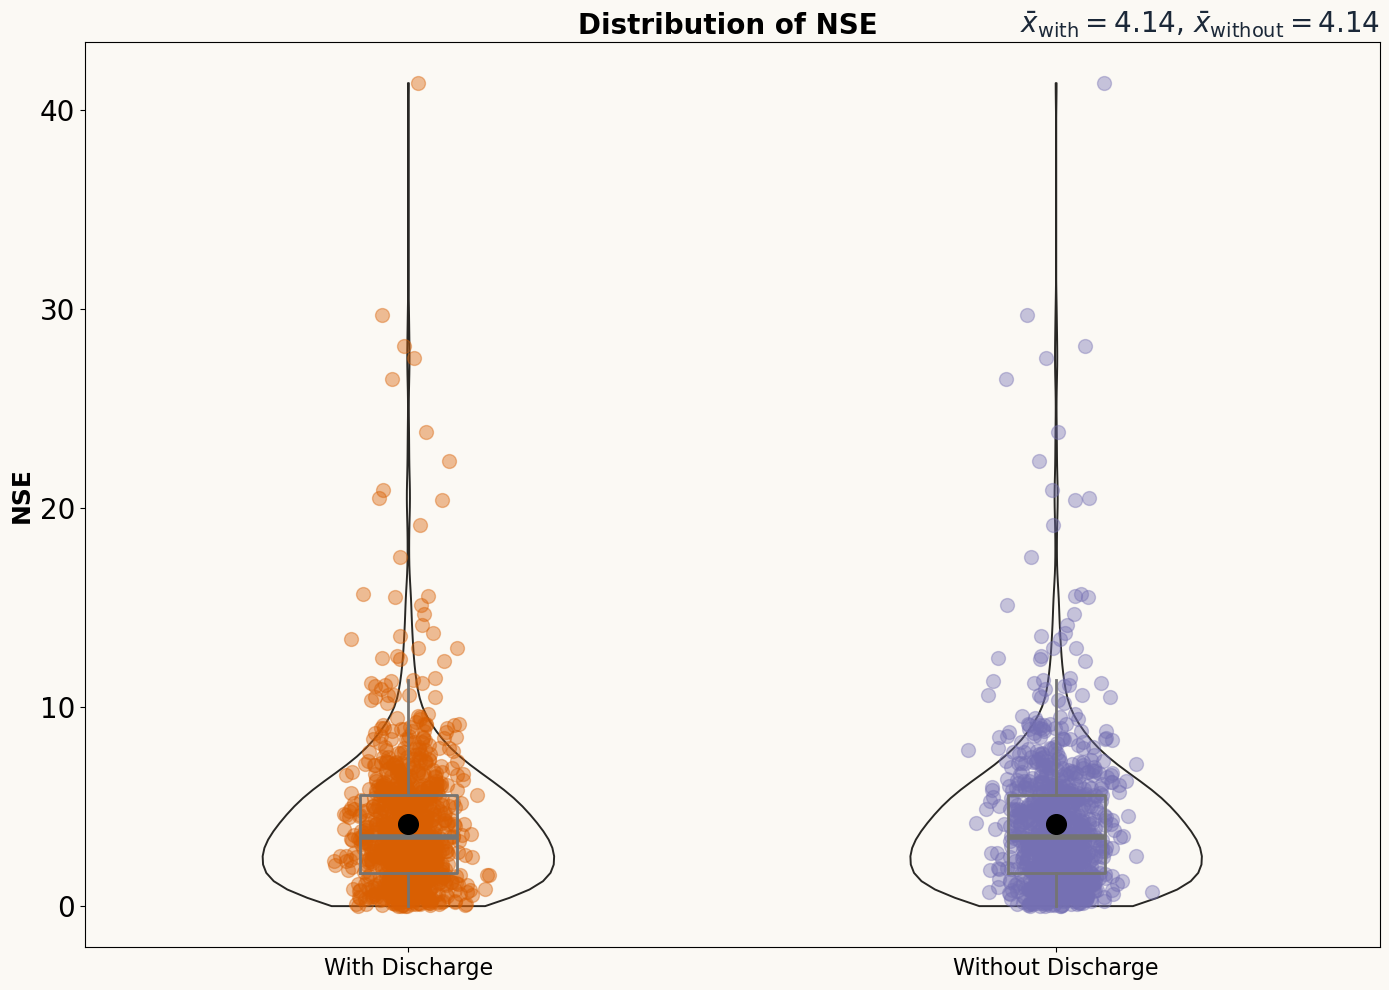

In [15]:
# Define colors and layout constants
# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"
POSITIONS = [1, 2]  # Positions for the violin plots
HLINES = np.arange(-0.5, 1.1, 0.1)  # Horizontal lines for reference

nse_disch_values = combined_results['avgprcp_with_discharge'].dropna()
nse_without_disch_values = combined_results['avgprcp_without_discharge'].dropna()

nse_disch_values = nse_disch_values[nse_disch_values >= 0]  # Keep only non-negative values
nse_without_disch_values = nse_without_disch_values[nse_without_disch_values >= 0]  # Keep only non-negative values

# Data for plotting
y_data = [nse_disch_values, nse_without_disch_values]
x_jittered = [np.random.normal(pos, 0.04, size=len(y)) for pos, y in zip(POSITIONS, y_data)]

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = [ "#D95F02", "#7570B3"]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Background color
fig.patch.set_facecolor(BG_WHITE)
ax.set_facecolor(BG_WHITE)


# Add violins
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)

# Add boxplots
medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers=False,  # Do not show the outliers beyond the caps
    showcaps=False,    # Do not show the caps
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops
)

# Add jittered dots
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s=100, color=color, alpha=0.4)

# Calculate and plot the mean
means = [np.mean(y) for y in y_data]

# Plot the means as red circles
ax.scatter(POSITIONS, means, color='black', s=200, zorder=3, label='Mean')


# Customize labels
ax.set_xticks(POSITIONS)
ax.tick_params(axis='both', labelsize=20)
ax.set_xticklabels(['With Discharge', 'Without Discharge'], size=16)
ax.set_ylabel('NSE', size=18, weight='bold')
ax.set_title('Distribution of NSE ', size=20, weight='bold')

# Subtitle
subtitle_stats = [
    r"$\bar{x}_{\rm{with}}=%.2f$" % np.mean(nse_disch_values),
    r"$\bar{x}_{\rm{without}}=%.2f$" % np.mean(nse_without_disch_values)
]

ax.set_title(
    ", ".join(subtitle_stats),
    loc="right",
    ha="right",
    fontsize=20,
    color=BLUE_DARK
)

# Adjust layout
plt.tight_layout()
#plt.savefig('violin_plot.jpeg', dpi =1200)
plt.show()


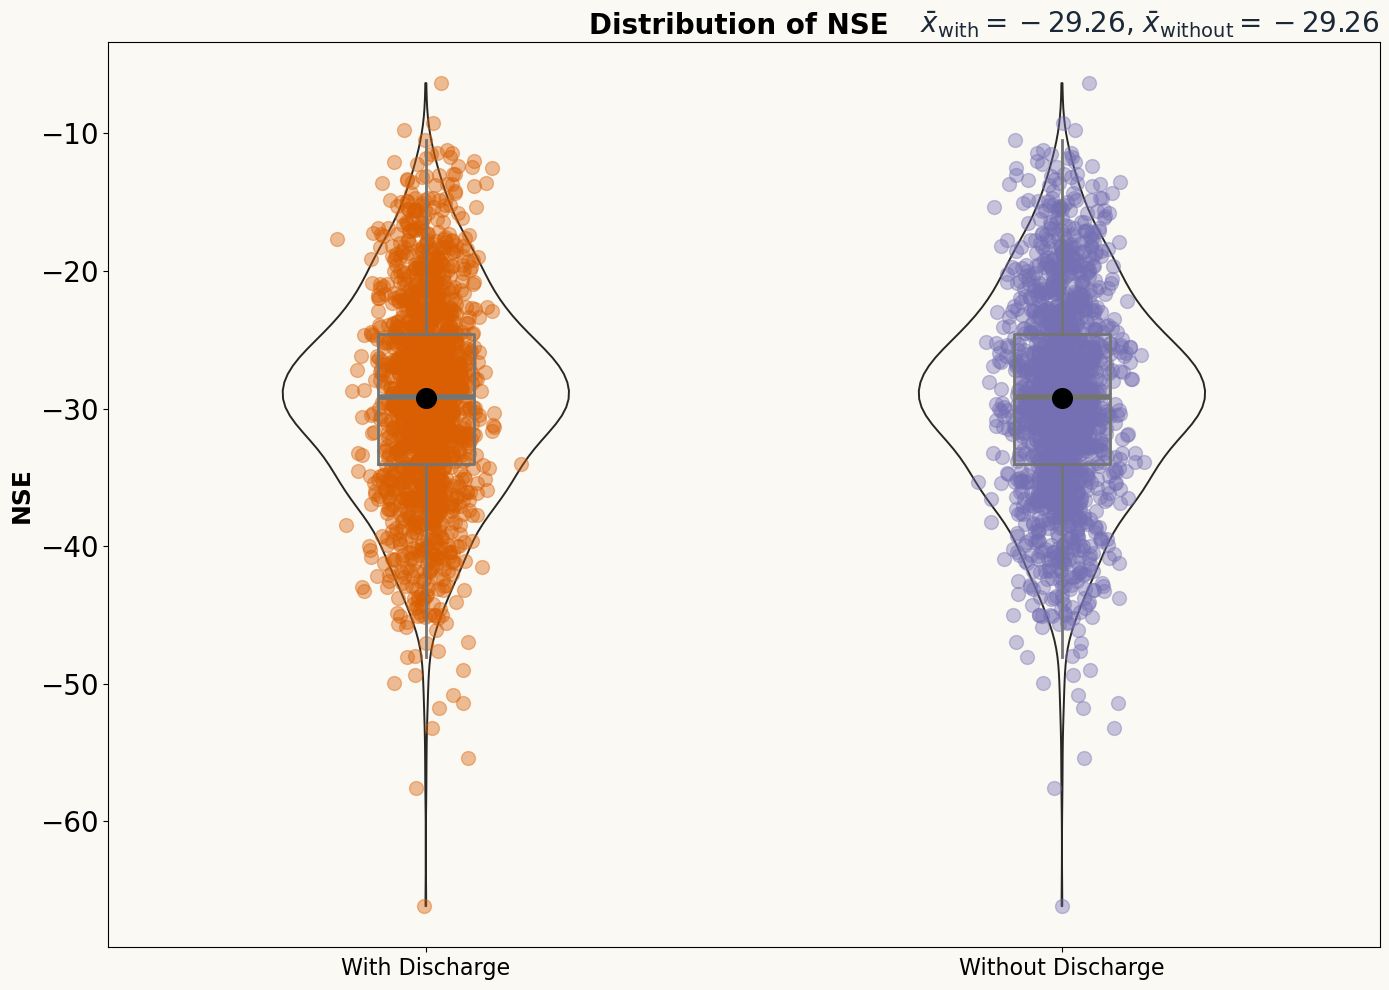

In [17]:
# Define colors and layout constants
# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"
POSITIONS = [1, 2]  # Positions for the violin plots
HLINES = np.arange(-0.5, 1.1, 0.1)  # Horizontal lines for reference

nse_disch_values = combined_results['stddev_with_discharge'].dropna()
nse_without_disch_values = combined_results['stddev_without_discharge'].dropna()

# Data for plotting
y_data = [nse_disch_values, nse_without_disch_values]
x_jittered = [np.random.normal(pos, 0.04, size=len(y)) for pos, y in zip(POSITIONS, y_data)]

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = [ "#D95F02", "#7570B3"]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Background color
fig.patch.set_facecolor(BG_WHITE)
ax.set_facecolor(BG_WHITE)


# Add violins
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)

# Add boxplots
medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers=False,  # Do not show the outliers beyond the caps
    showcaps=False,    # Do not show the caps
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops
)

# Add jittered dots
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s=100, color=color, alpha=0.4)

# Calculate and plot the mean
means = [np.mean(y) for y in y_data]

# Plot the means as red circles
ax.scatter(POSITIONS, means, color='black', s=200, zorder=3, label='Mean')


# Customize labels
ax.set_xticks(POSITIONS)
ax.tick_params(axis='both', labelsize=20)
ax.set_xticklabels(['With Discharge', 'Without Discharge'], size=16)
ax.set_ylabel('NSE', size=18, weight='bold')
ax.set_title('Distribution of NSE ', size=20, weight='bold')

# Subtitle
subtitle_stats = [
    r"$\bar{x}_{\rm{with}}=%.2f$" % np.mean(nse_disch_values),
    r"$\bar{x}_{\rm{without}}=%.2f$" % np.mean(nse_without_disch_values)
]

ax.set_title(
    ", ".join(subtitle_stats),
    loc="right",
    ha="right",
    fontsize=20,
    color=BLUE_DARK
)

# Adjust layout
plt.tight_layout()
#plt.savefig('violin_plot.jpeg', dpi =1200)
plt.show()


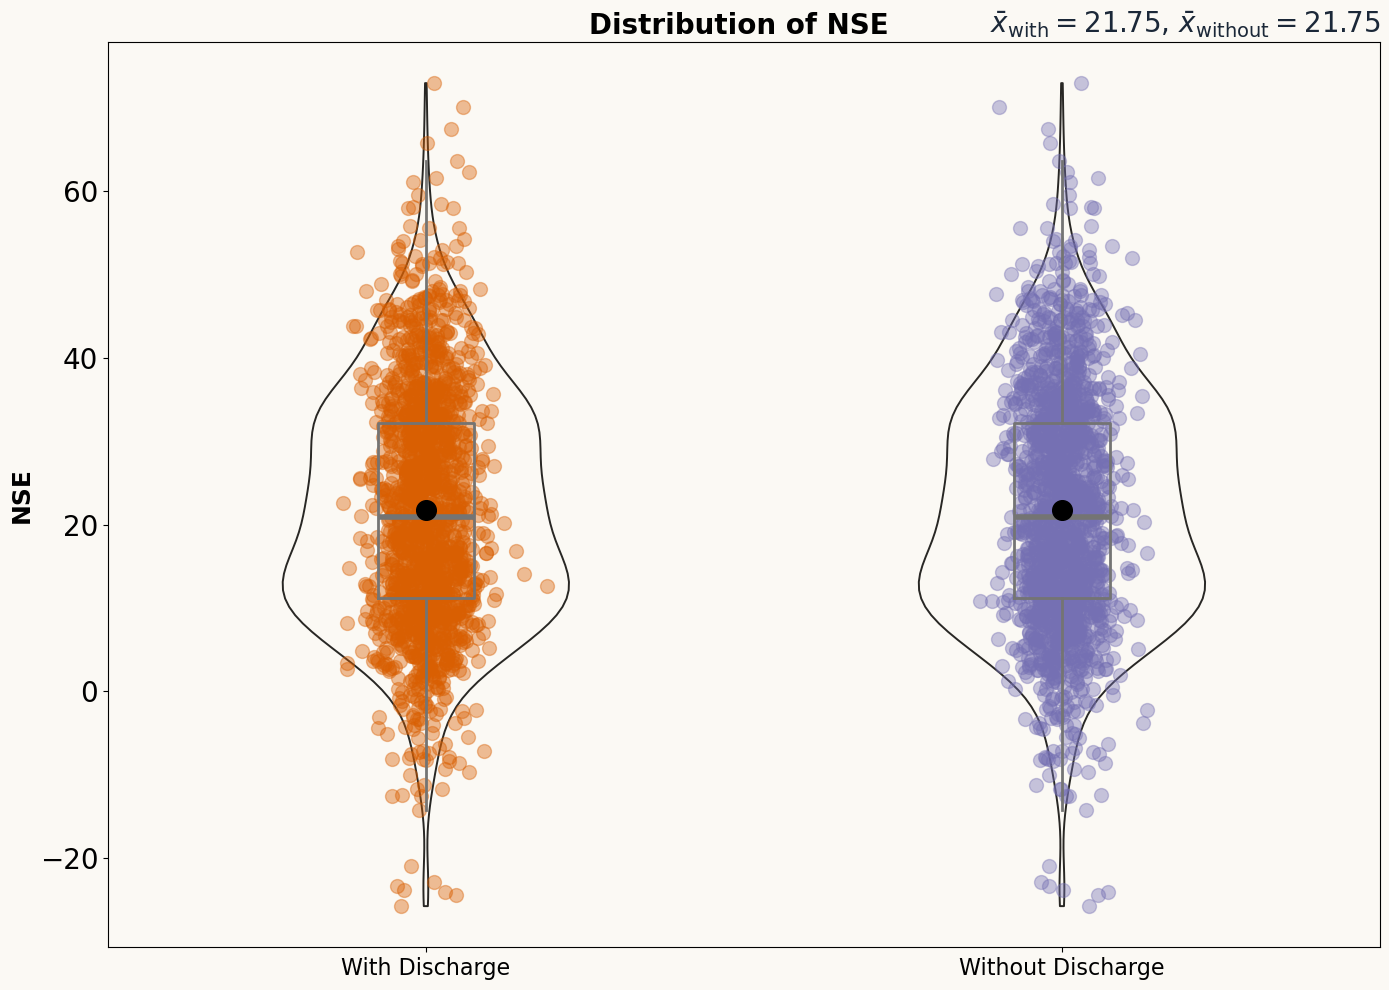

In [18]:
# Define colors and layout constants
# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"
POSITIONS = [1, 2]  # Positions for the violin plots
HLINES = np.arange(-0.5, 1.1, 0.1)  # Horizontal lines for reference

nse_disch_values = combined_results['spearman_lag1_with_discharge'].dropna()
nse_without_disch_values = combined_results['spearman_lag1_without_discharge'].dropna()

# Data for plotting
y_data = [nse_disch_values, nse_without_disch_values]
x_jittered = [np.random.normal(pos, 0.04, size=len(y)) for pos, y in zip(POSITIONS, y_data)]

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = [ "#D95F02", "#7570B3"]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Background color
fig.patch.set_facecolor(BG_WHITE)
ax.set_facecolor(BG_WHITE)


# Add violins
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)

# Add boxplots
medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers=False,  # Do not show the outliers beyond the caps
    showcaps=False,    # Do not show the caps
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops
)

# Add jittered dots
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s=100, color=color, alpha=0.4)

# Calculate and plot the mean
means = [np.mean(y) for y in y_data]

# Plot the means as red circles
ax.scatter(POSITIONS, means, color='black', s=200, zorder=3, label='Mean')


# Customize labels
ax.set_xticks(POSITIONS)
ax.tick_params(axis='both', labelsize=20)
ax.set_xticklabels(['With Discharge', 'Without Discharge'], size=16)
ax.set_ylabel('NSE', size=18, weight='bold')
ax.set_title('Distribution of NSE ', size=20, weight='bold')

# Subtitle
subtitle_stats = [
    r"$\bar{x}_{\rm{with}}=%.2f$" % np.mean(nse_disch_values),
    r"$\bar{x}_{\rm{without}}=%.2f$" % np.mean(nse_without_disch_values)
]

ax.set_title(
    ", ".join(subtitle_stats),
    loc="right",
    ha="right",
    fontsize=20,
    color=BLUE_DARK
)

# Adjust layout
plt.tight_layout()
#plt.savefig('violin_plot.jpeg', dpi =1200)
plt.show()
